# Analyze player counts and game updates (patches) for Top 11 Steam RTS games

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import savgol_filter
from datetime import datetime
import numpy as np

data_dir = '../../data/'
steamdb_dir = f'{data_dir}steamdb/player-charts/'  # read chart-{game}.html files from steamdb.info
gen_dir = f'{data_dir}gen/'          # read generated patch_counts.csv from here
out_dir = '../../outputs/rts-player-counts/' # save graphs here


In [2]:
dfs = dict()
for filename in os.listdir(steamdb_dir):
    f = os.path.join(steamdb_dir, filename)
    if os.path.isfile(f):
        df_name = filename[6:-4] # files manually saved as `chart-game.csv` -> game
        # print(f'Adding df: {df_name}')
        dfs[df_name] = pd.read_csv(f, usecols=['DateTime', 'Players'])

## Data Cleaning

In [3]:
# Clean data, impute Player counts for missing values
for game, df in dfs.items():
    # print(game)
    df.set_index('DateTime')
    # df['Players'] = df['Players'].interpolate(method='linear', inplace=True)
    df.dropna(subset=['Players'], inplace=True)
    # df['Players'] = df['Players'].round()
    df = df.astype({'Players': int})

## Analyze game updates in terms of update frequency and player counts

In [4]:
# get game update stats and add update frequency to it later
patch_counts = pd.read_csv(f'{gen_dir}patch_counts.csv')
patch_counts['days_since_launch'] = np.zeros(len(patch_counts))-1


/var/folders/zx/f3rt3pyx58xg7vm_jv6_g3jh0000gn/T/ipykernel_44669/931693216.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(8,6))


<Figure size 576x432 with 0 Axes>

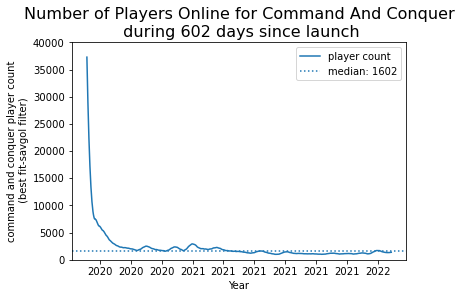

<Figure size 576x432 with 0 Axes>

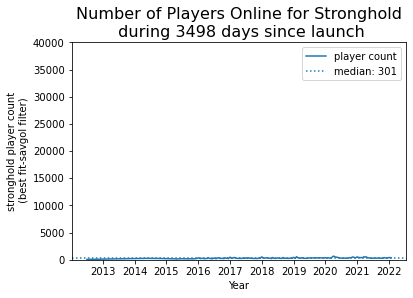

<Figure size 576x432 with 0 Axes>

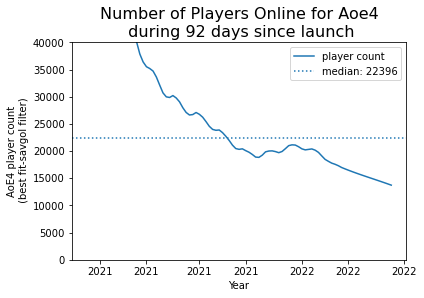

<Figure size 576x432 with 0 Axes>

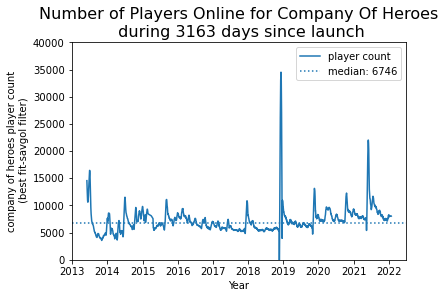

<Figure size 576x432 with 0 Axes>

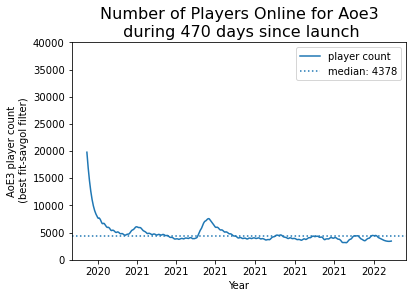

<Figure size 576x432 with 0 Axes>

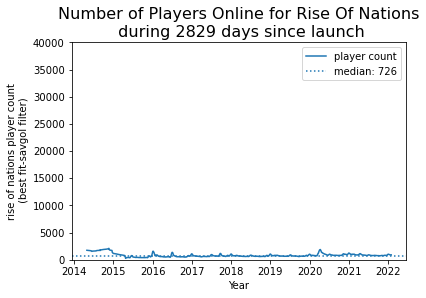

<Figure size 576x432 with 0 Axes>

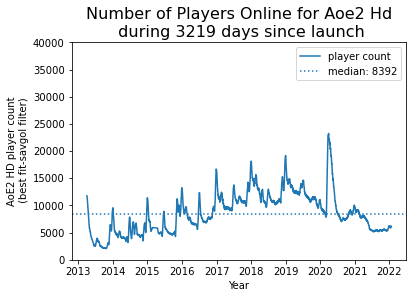

<Figure size 576x432 with 0 Axes>

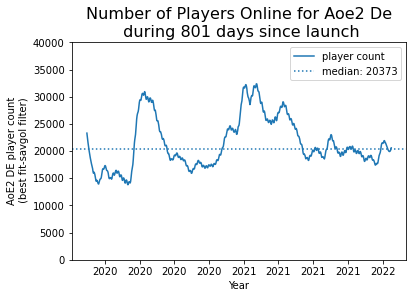

<Figure size 576x432 with 0 Axes>

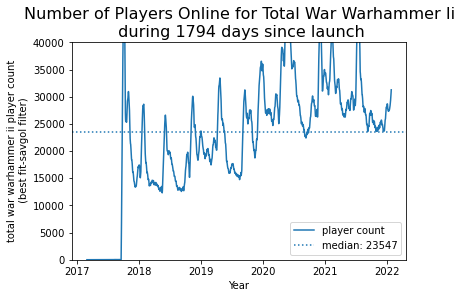

<Figure size 576x432 with 0 Axes>

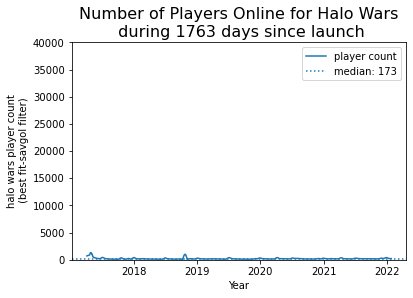

<Figure size 576x432 with 0 Axes>

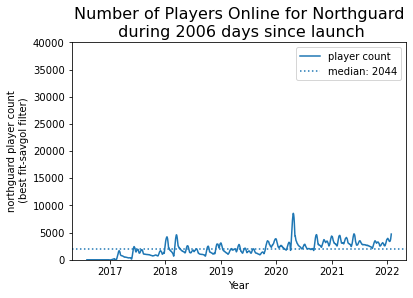

In [5]:
# Plot all games' player counts
# side effect: this also gets the update frequency TODO refactor
for game, df in dfs.items():
    days = pd.to_datetime(df['DateTime'])
    min_ = datetime.strptime(df.DateTime.min(), "%Y-%m-%d %H:%M:%S")
    max_ = datetime.strptime(df.DateTime.max(), "%Y-%m-%d %H:%M:%S")
    delta = (max_ - min_).days

    # Update how long people have been playing this game and how many players play
    patch_counts.loc[patch_counts['name'] == game,'days_since_launch'] = delta
    median_players = int(round(df.Players.median(),0))
    patch_counts.loc[patch_counts['name'] == game,'median_players'] = median_players

    num_players_filtered = df[['Players']].apply(savgol_filter, window_length=31, polyorder=3)

    plt.figure(figsize=(8,6))
    _, ax = plt.subplots()
    plt.plot(days, num_players_filtered, label='player count')
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    # plt.scatter(days, df['Players']) # uncomment if we want actual player values
    plt.ylabel(f'{game.replace("-", " ")} player count\n (best fit-savgol filter)')
    plt.xlabel('Year')
    plt.axhline(median_players, linestyle=":", label=f"median: {median_players}")
    plt.title(f'Number of Players Online for {game.replace("-", " ").title()}\n '
              f'during {delta} days since launch', fontsize=16)
    plt.legend()
    axes = plt.gca()
    axes.set_ylim([0,40000])

    plt.savefig(f'{out_dir}{game}.png', bbox_inches='tight')
    # plt.show()


### Look at game update frequency
### Save statistics

In [6]:
patch_counts # now updated with days_since_launch
patch_counts['days_between_updates'] = patch_counts.days_since_launch/patch_counts.num_updates
# patch_counts.sort_values(by='days_between_updates')
patch_counts.sort_values(by='median_players')
# patch_counts[['name', 'num_updates', 'days_between_updates', 'days_since_launch']].agg(['mean', 'median', 'std'])

patch_counts.to_csv(f'{out_dir}patches_freq.csv')


### Visualize game update frequency vs player number (and linear regression)

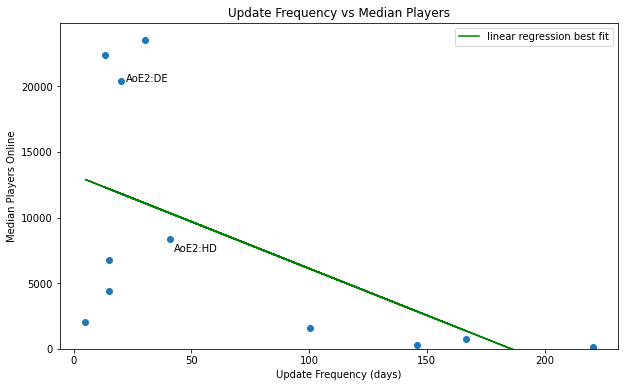

In [7]:
# Plot frequency of updates vs num players per game
plt.figure(figsize=(10,6))
plt.scatter(x=patch_counts.days_between_updates, y=patch_counts.median_players)
plt.annotate('AoE2:DE', xy=(patch_counts.days_between_updates[9], patch_counts.median_players[9]),
             xytext=(patch_counts.days_between_updates[9]+2.0, patch_counts.median_players[9]))
plt.annotate('AoE2:HD', xy=(patch_counts.days_between_updates[10], patch_counts.median_players[10]),
             xytext=(patch_counts.days_between_updates[10]+2.0, (patch_counts.median_players[10]-1000.0)))
plt.title('Update Frequency vs Median Players')
plt.xlabel('Update Frequency (days)')
plt.ylabel('Median Players Online')
# Linear regression best fit line https://pythonguides.com/matplotlib-best-fit-line/
dt = np.array(list(zip(patch_counts.days_between_updates, patch_counts.median_players)))
x = dt[:, 0].reshape(dt.shape[0], 1)
X = np.append(x, np.ones((dt.shape[0], 1)), axis=1)
y = dt[:, 1].reshape(dt.shape[0], 1)
theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
y_line = X.dot(theta)
plt.plot(x, y_line, 'g', label='linear regression best fit')
plt.ylim(bottom=0)
plt.legend()

plt.savefig(f'{out_dir}frequency-vs-players.png', bbox_inches='tight')
